Using TensorFlow backend.


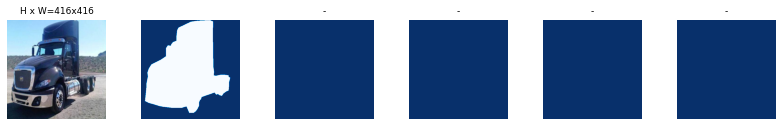

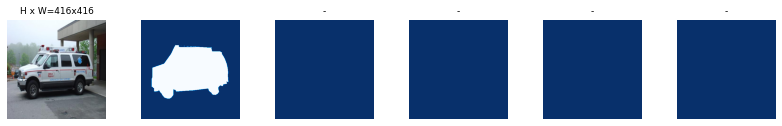

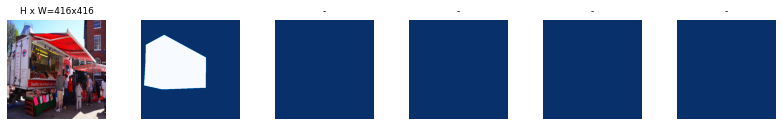

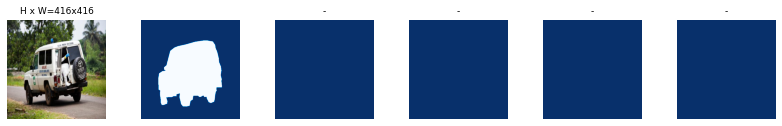

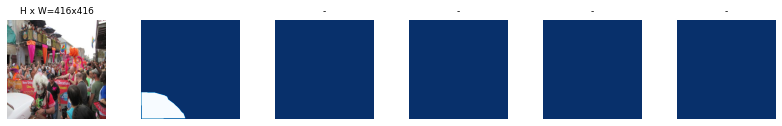

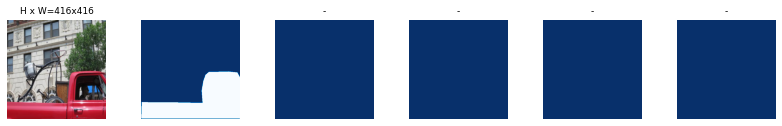

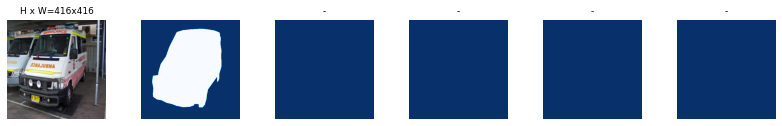

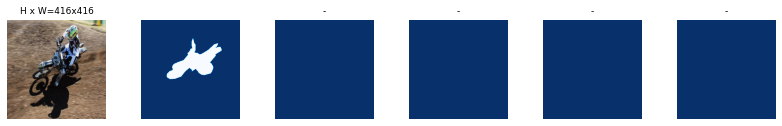

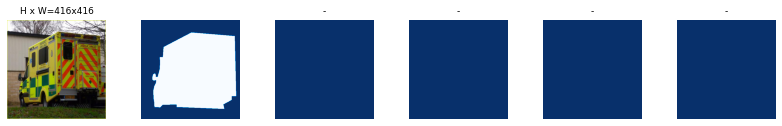

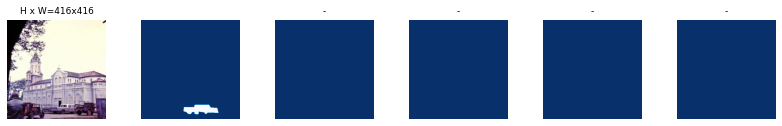

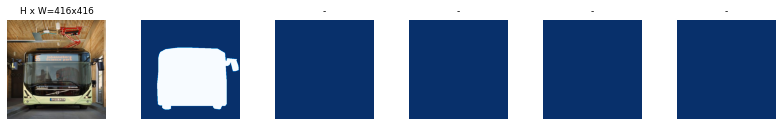

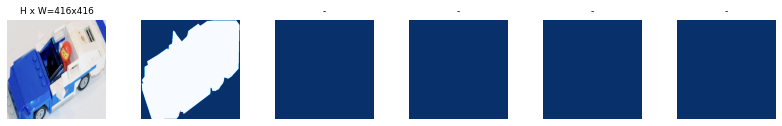

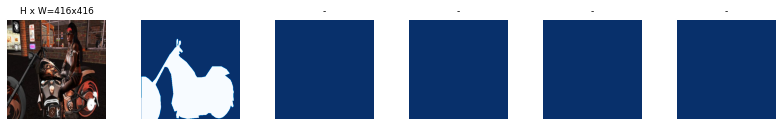

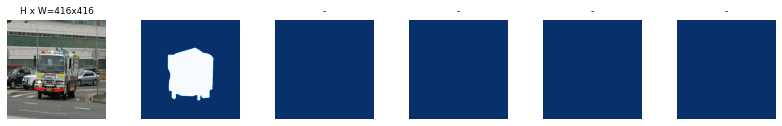

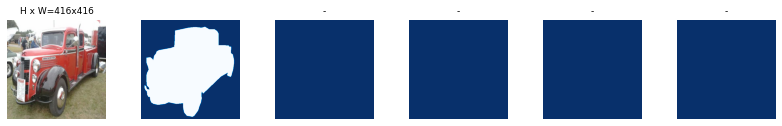

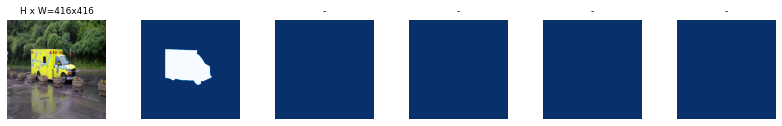

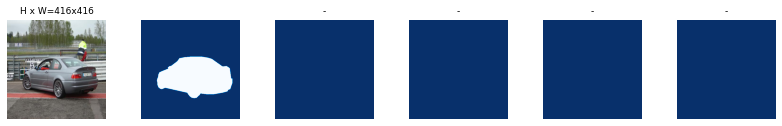

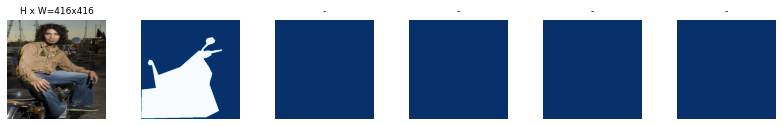

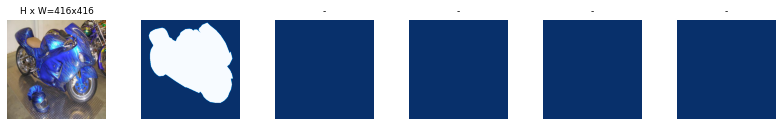

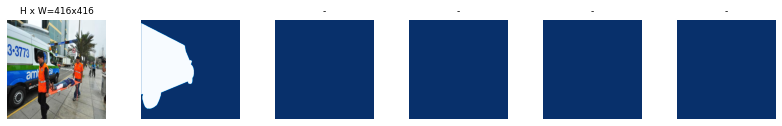

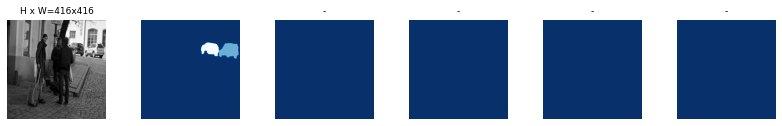

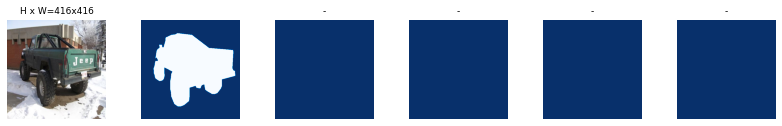

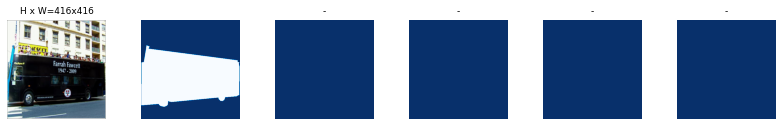

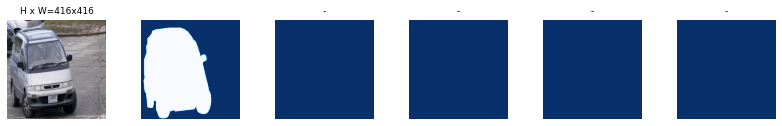

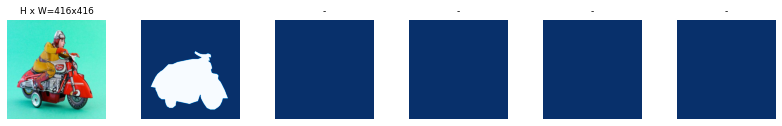

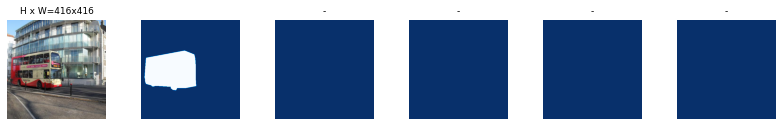

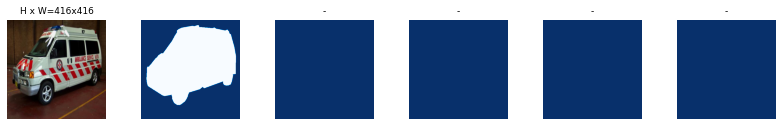

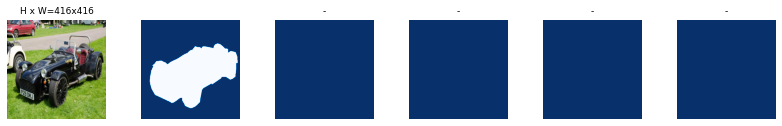

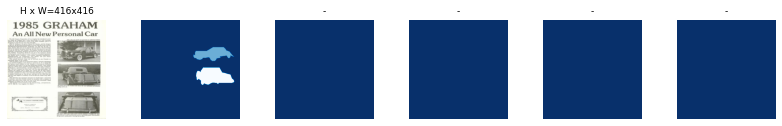

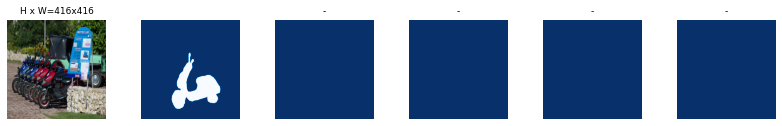

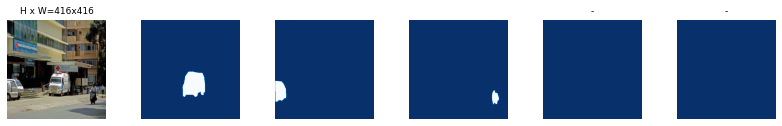

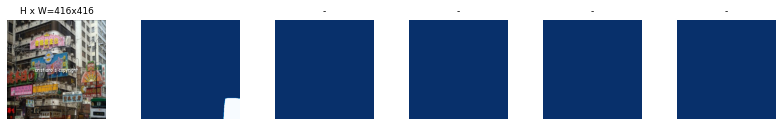

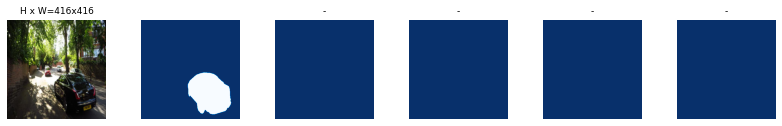

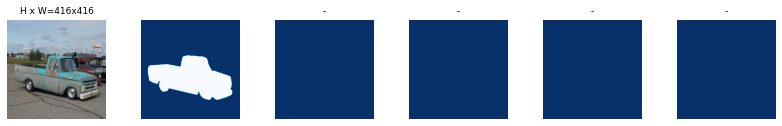

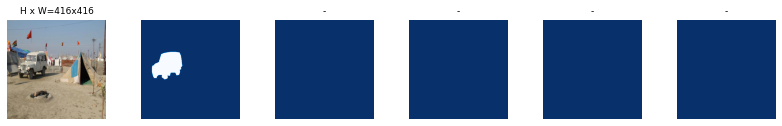

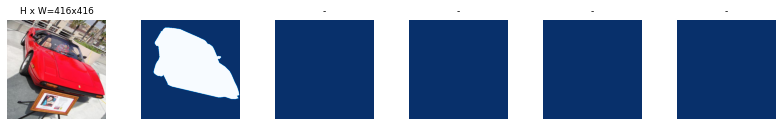

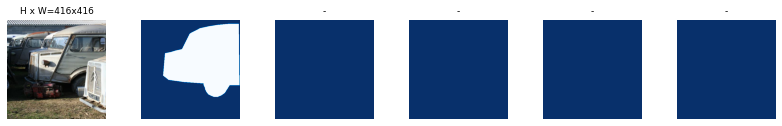

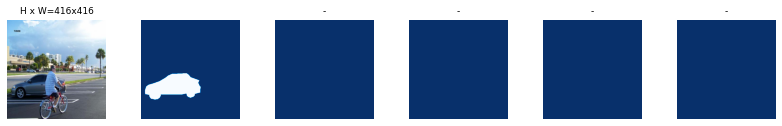

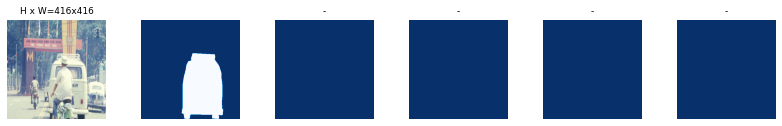

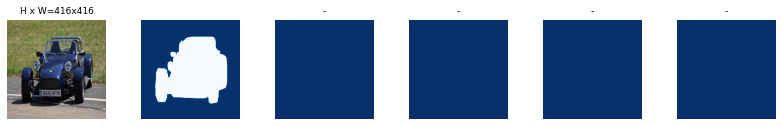

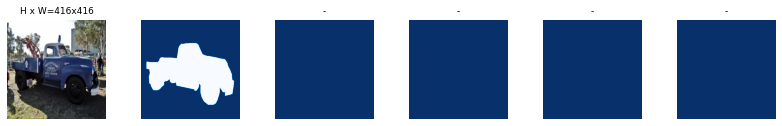

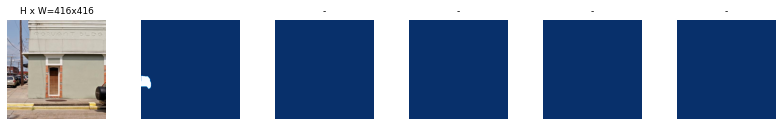

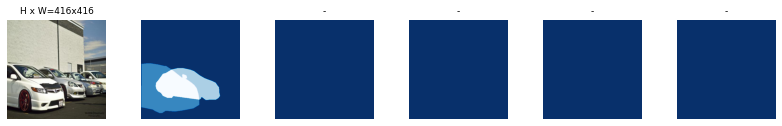

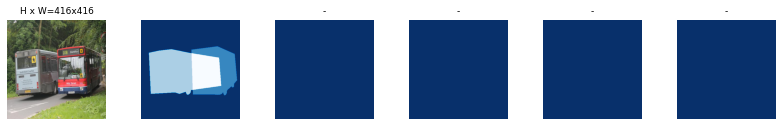

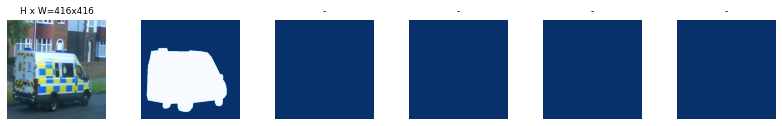

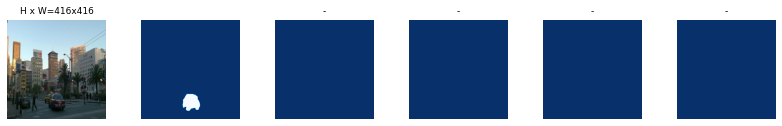

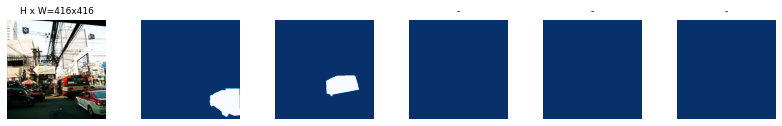

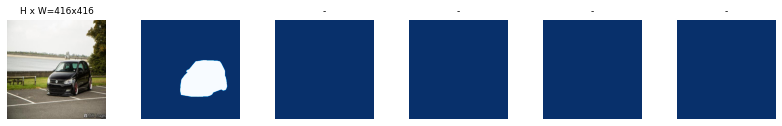

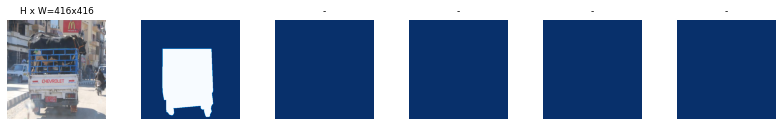

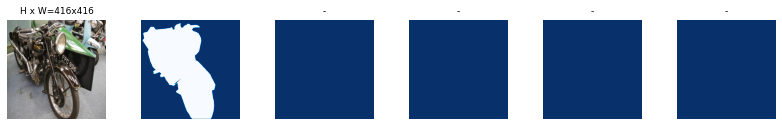

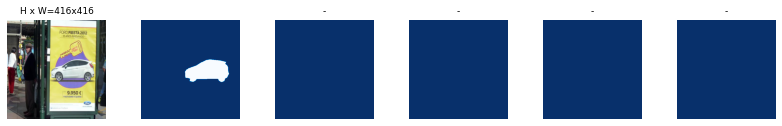

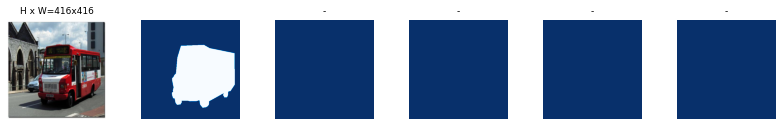

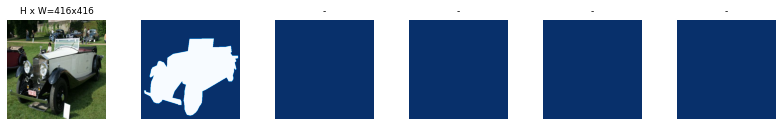

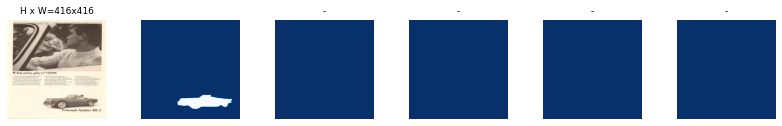

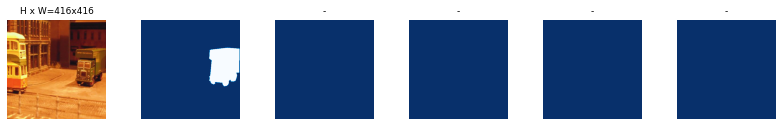

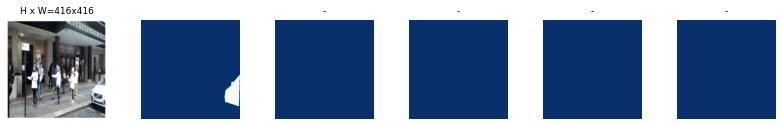

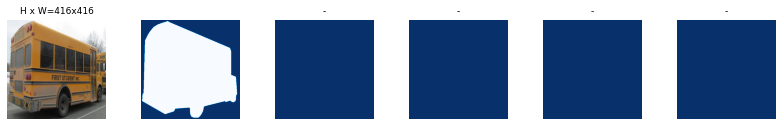

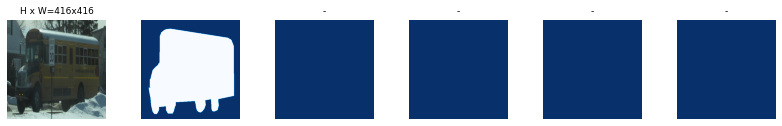

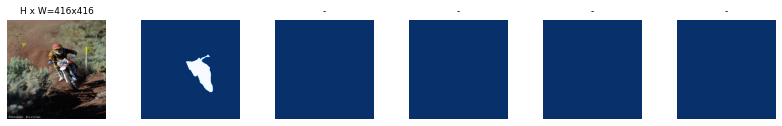

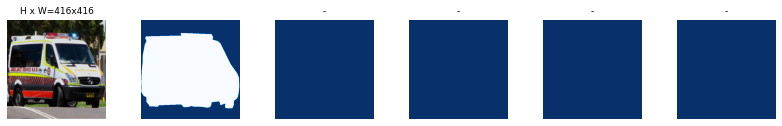

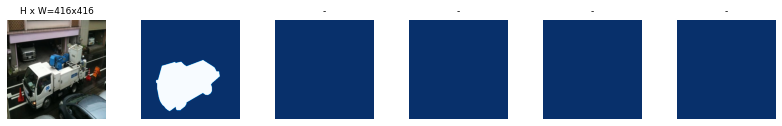

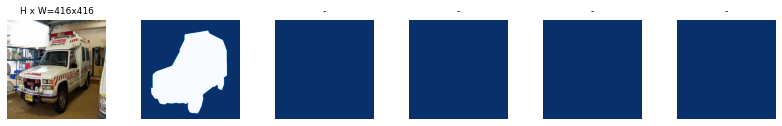

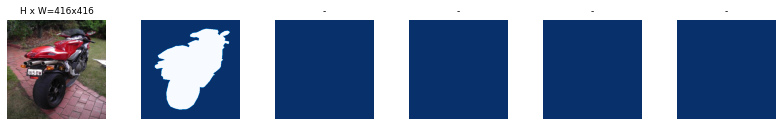

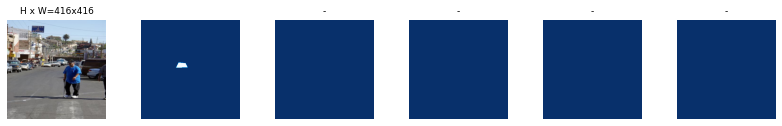

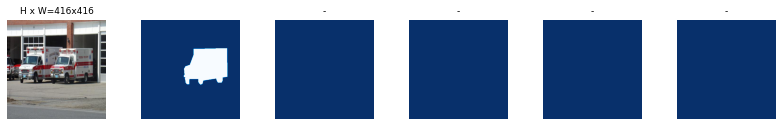

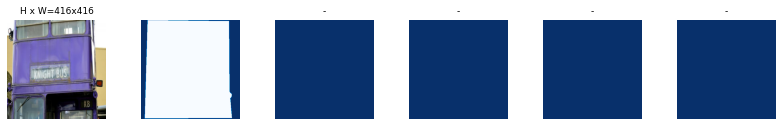

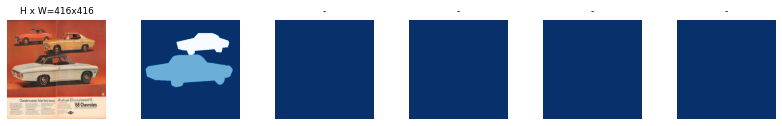

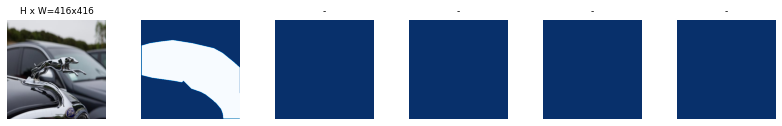

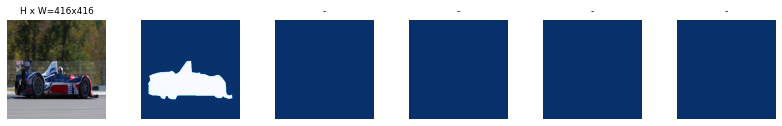

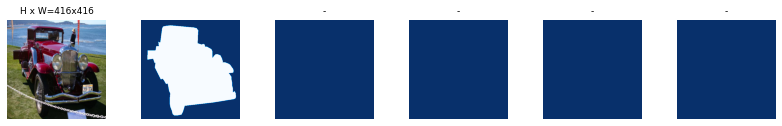

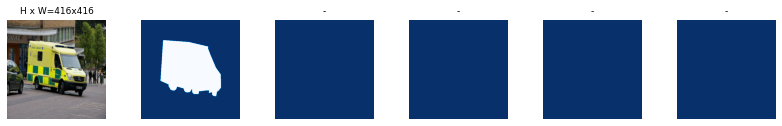

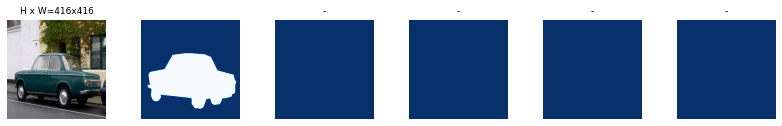

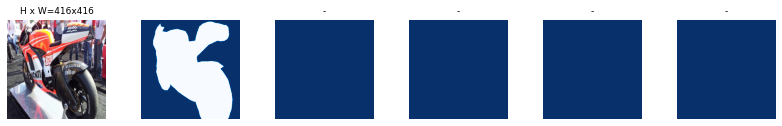

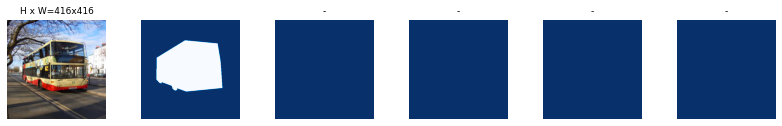

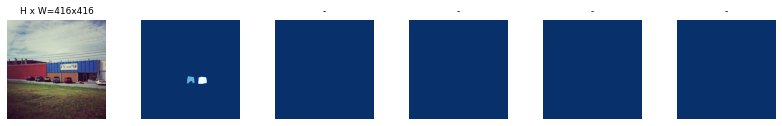

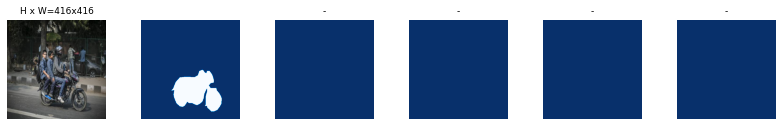

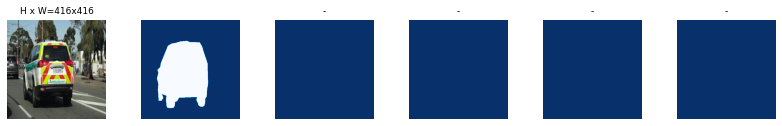

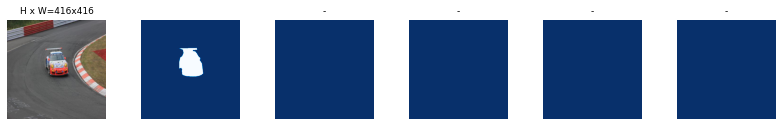

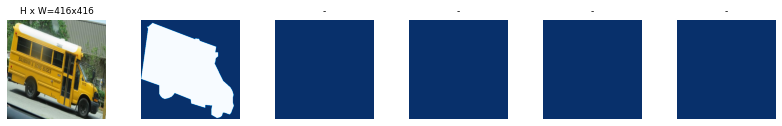

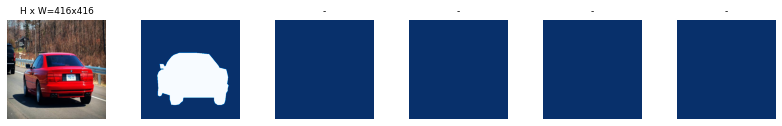

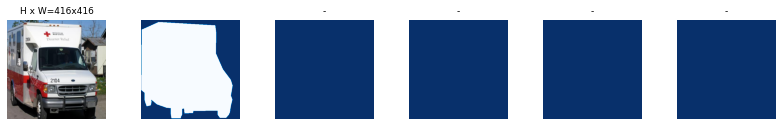

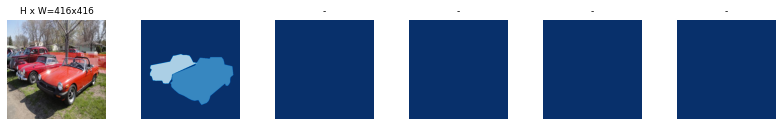

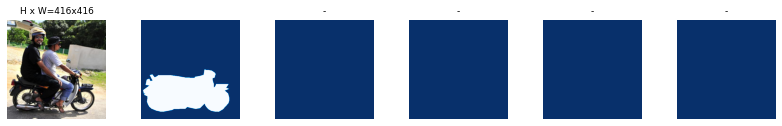

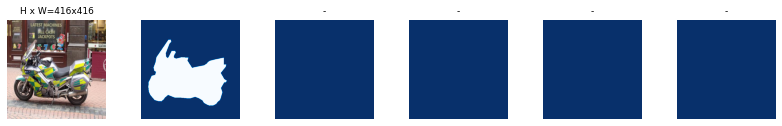

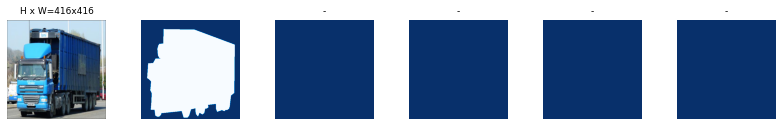

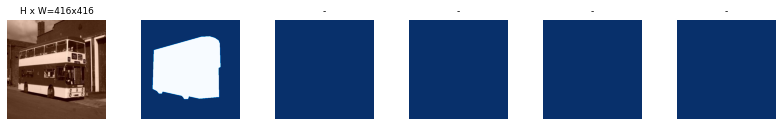

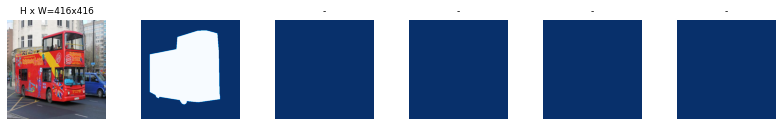

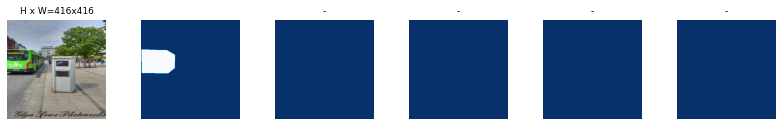

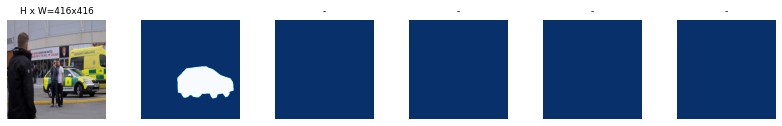

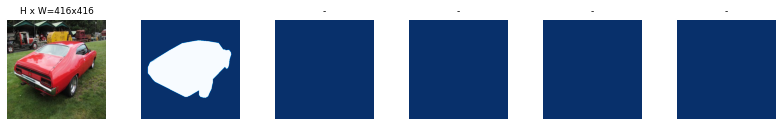

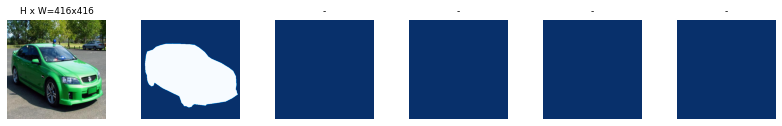

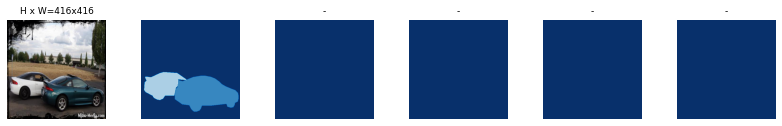

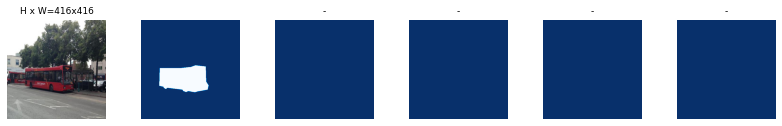

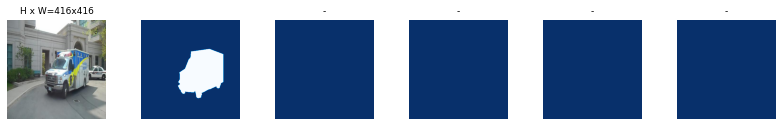

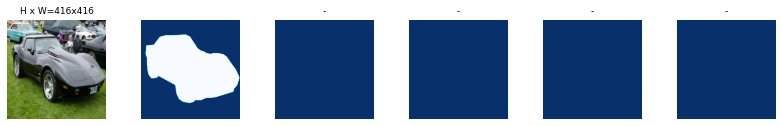

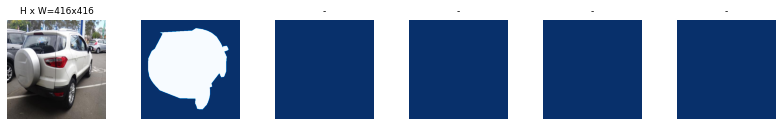

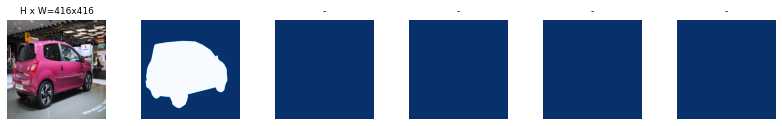

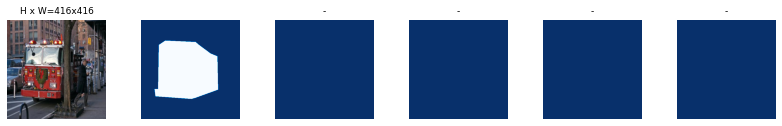

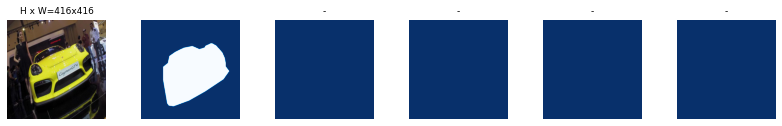

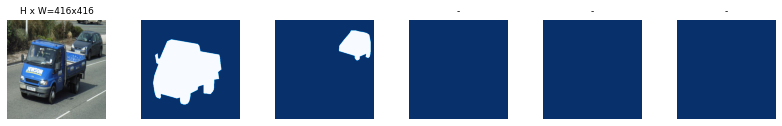

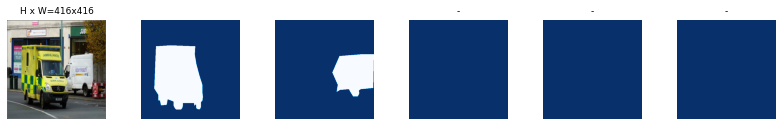

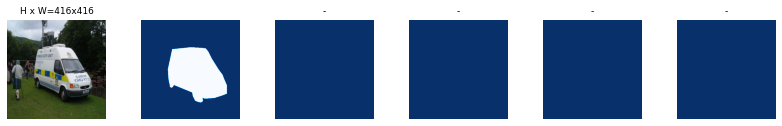

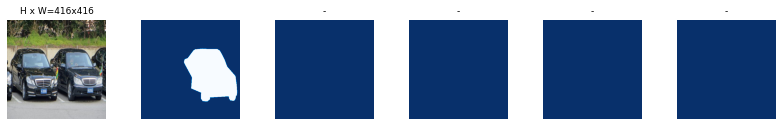

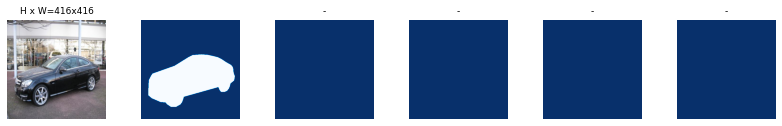

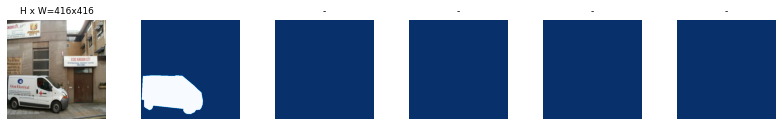

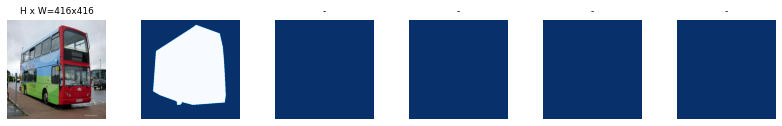

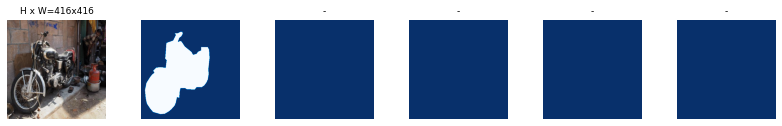

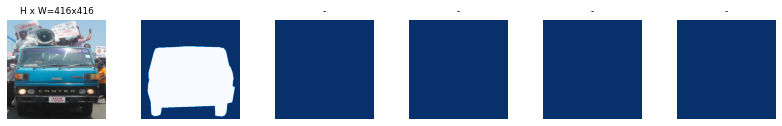

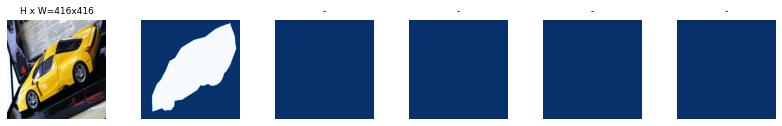

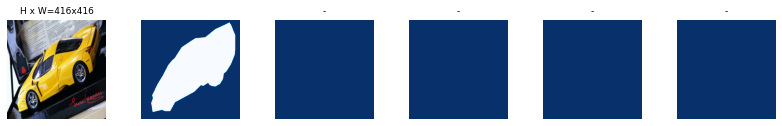

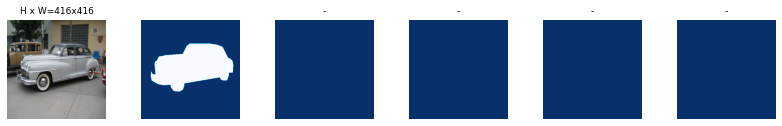

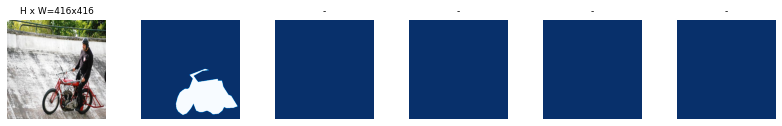

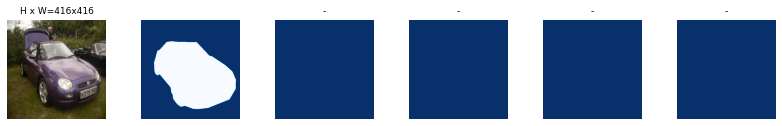

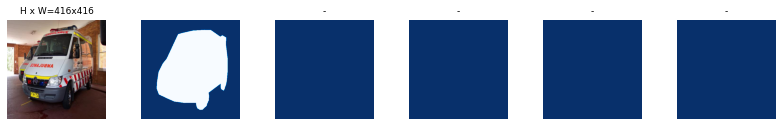

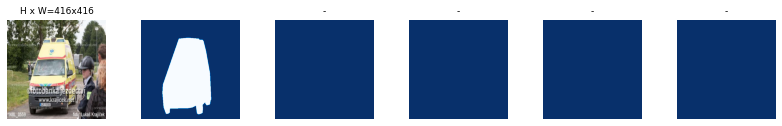

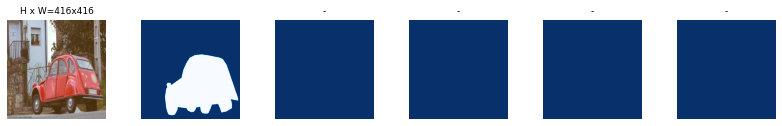

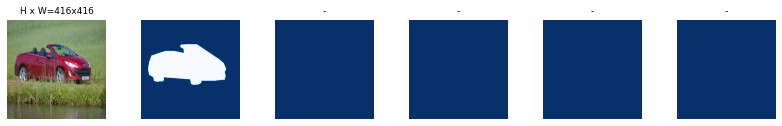

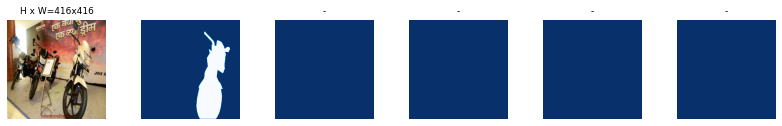

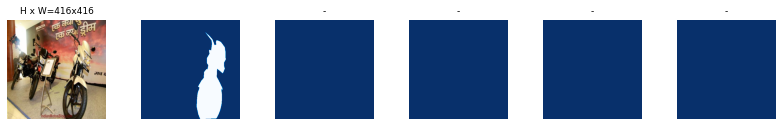

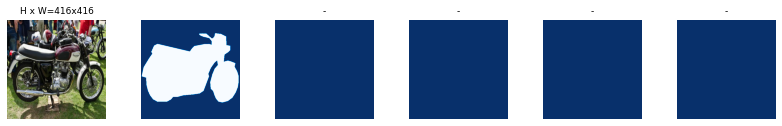

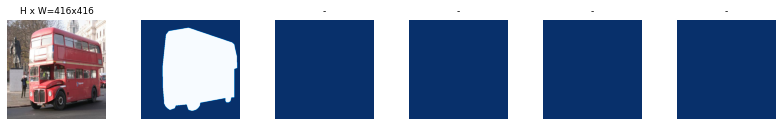

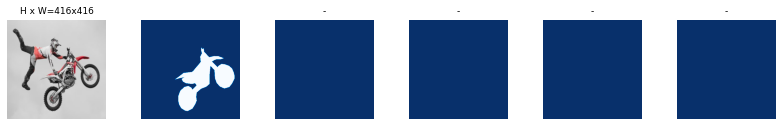

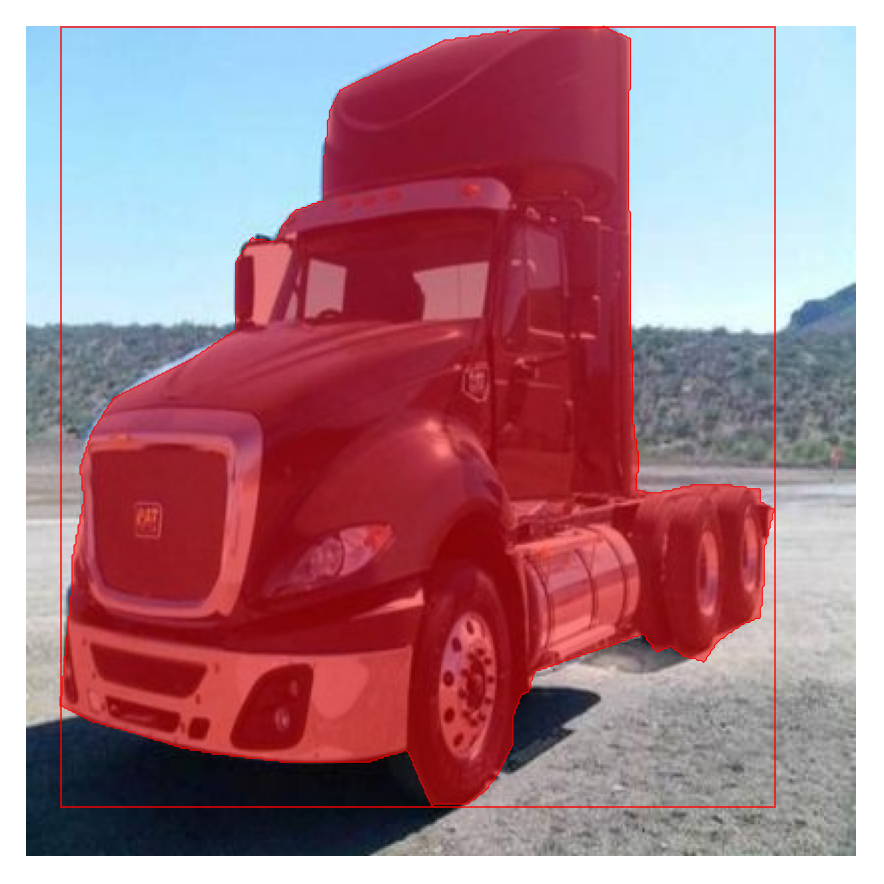


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

d:\anaconda\envs\mask-rcnn2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
100/100 [==============================] - 7269s 73s/step - loss: 1.3358 - val_loss: 0.5239
Epoch 2/5
100/100 [==============================] - 7078s 71s/step - loss: 0.5537 - val_loss: 0.2713
Epoch 3/5
100/100 [==============================] - 7138s 71s/step - loss: 0.4371 - val_loss: 0.4306
Epoch 4/5
100/100 [==============================] - 7075s 71s/step - loss: 0.3854 - val_loss: 0.2653
Epoch 5/5
100/100 [==============================] - 7090s 71s/step - loss: 0.3509 - val_loss: 0.1941


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# import tensorflow as tf
import sys
import json
import datetime
import numpy as np
import skimage.draw
import numpy as np
from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes

from mrcnn.utils import Dataset
from matplotlib import pyplot as plt

from mrcnn.config import Config
from mrcnn.model import MaskRCNN


from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw


#########################
# tf.config.set_visible_devices([], 'GPU')
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
    # @tf.function            
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids
    



##############################


dataset_train = CocoLikeDataset()
dataset_train.load_data(r"C:\Users\hp\Documents\datasets\Mask_RCNN\train_annotations_coco.json", r"C:\Users\hp\Documents\newDataset\train1")
dataset_train.prepare()

#In this example, I do not have annotations for my validation data, so I am loading train data
dataset_val = CocoLikeDataset()
dataset_val.load_data(r"C:\Users\hp\Documents\datasets\Mask_RCNN\val_annotions_coco.json", r"C:\Users\hp\Documents\newDataset\val1")
dataset_val.prepare()


dataset = dataset_train
image_ids = dataset.image_ids
#image_ids = np.random.choice(dataset.image_ids, 3)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # class_ids = class_ids.numpy().tolist()
    display_top_masks(image, mask, class_ids, dataset.class_names, limit=5)  #limit to total number of classes



# define image id
image_id = 0
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)

# display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
# dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)


# define a configuration for the model
class MarbleConfig(Config):
	# define the name of the configuration
	NAME = "marble_cfg_coco"
	# number of classes (background + blue marble + non-Blue marble)
	NUM_CLASSES = 1 + 5
	# number of training steps per epoch
	STEPS_PER_EPOCH = 100
    #DETECTION_MIN_CONFIDENCE = 0.9 # Skip detections with < 90% confidence
# prepare config
config = MarbleConfig()
config.display() 




ROOT_DIR = os.path.abspath(r"C:\Users\hp\Documents\maskRCNN")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Directory to save logs and trained model
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco (1).h5")

########################
#Weights are saved to root D: directory. need to investigate how they can be
#saved to the directory defined... "logs_models"

###############

# define the model
model = MaskRCNN(mode='training', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(dataset_train, dataset_train, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')

In [ ]:
from mrcnn.model import MaskRCNN

# define the model
model = MaskRCNN(mode='inference', model_dir=DEFAULT_LOGS_DIR, config=config)
# load weights (mscoco)
#model.load_weights(COCO_WEIGHTS_PATH, by_name=True)

# Evaluate model on validation dataset and calculate mAP
image_ids = dataset_val.image_ids
total_detection_loss = 0
total_mask_loss = 0
total_losses = 0
num_images = len(image_ids)

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_ids, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute loss
    detection_loss = r['detection_loss']
    mask_loss = r['mask_loss']
    total_detection_loss += detection_loss
    total_mask_loss += mask_loss
    total_losses += detection_loss + mask_loss

# Calculate average loss
average_detection_loss = total_detection_loss / num_images
average_mask_loss = total_mask_loss / num_images
average_total_loss = total_losses / num_images

# Calculate mAP
mAP = model.compute_ap_range(dataset_val, config, iou_thresholds=[0.5])

print("Average Detection Loss: {:.4f}".format(average_detection_loss))
print("Average Mask Loss: {:.4f}".format(average_mask_loss))
print("Average Total Loss: {:.4f}".format(average_total_loss))
print("mAP: {:.4f}".format(mAP))

